In [1]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime 
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

In [2]:
def download_data():
    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()

    # Specify the dataset
    dataset = "atharvasoundankar/global-music-streaming-trends-and-listener-insights"

    # Download the dataset
    api.dataset_download_files(dataset, path="./data", unzip=True)

    print("Dataset downloaded successfully!")

download_data()

Dataset URL: https://www.kaggle.com/datasets/atharvasoundankar/global-music-streaming-trends-and-listener-insights
Dataset downloaded successfully!


In [3]:
def load_data():
    dataset_path = "/home/joy/.cache/kagglehub/datasets/atharvasoundankar/global-music-streaming-trends-and-listener-insights/versions/1"
    file_path = os.path.join(dataset_path, "Global_Music_Streaming_Listener_Preferences.csv")
    df = pd.read_csv(file_path)
    df.to_csv("/tmp/music_data.csv", index=False)
load_data()
    

In [4]:
def data_cleaning():
    df = pd.read_csv("/tmp/music_data.csv")
    
    # Drop rows with null values
    df.dropna(inplace=True)
    
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    save_path = "/home/joy/Documents/music_data"
    os.makedirs(save_path, exist_ok=True)  # Ensure directory exists

    # Save cleaned data
    cleaned_data_path = os.path.join(save_path, "music_data_cleaned.csv")
    df.to_csv(cleaned_data_path, index=False)
    print(f"Cleaned data saved to {cleaned_data_path}")
data_cleaning()

Cleaned data saved to /home/joy/Documents/music_data/music_data_cleaned.csv


In [5]:
def exploratory_analysis():
    df = pd.read_csv("/home/joy/Documents/music_data/music_data_cleaned.csv")
    print(df.head())
exploratory_analysis()

  User_ID  Age    Country Streaming Platform Top Genre  \
0   U1000   34      Japan              Tidal    Reggae   
1   U1001   24    Germany             Deezer   Country   
2   U1002   49    Germany             Deezer       Pop   
3   U1003   55  Australia            YouTube    Reggae   
4   U1004   13    Germany       Amazon Music    Reggae   

   Minutes Streamed Per Day  Number of Songs Liked Most Played Artist  \
0                       295                    138              Adele   
1                        86                    388         Ed Sheeran   
2                       363                    368        Post Malone   
3                       348                    349           Dua Lipa   
4                        30                    328              Adele   

  Subscription Type Listening Time (Morning/Afternoon/Night)  \
0              Free                                Afternoon   
1           Premium                                    Night   
2           Premium 

Visualizations saved to /home/joy/Documents/music_data/music_visualizations.png


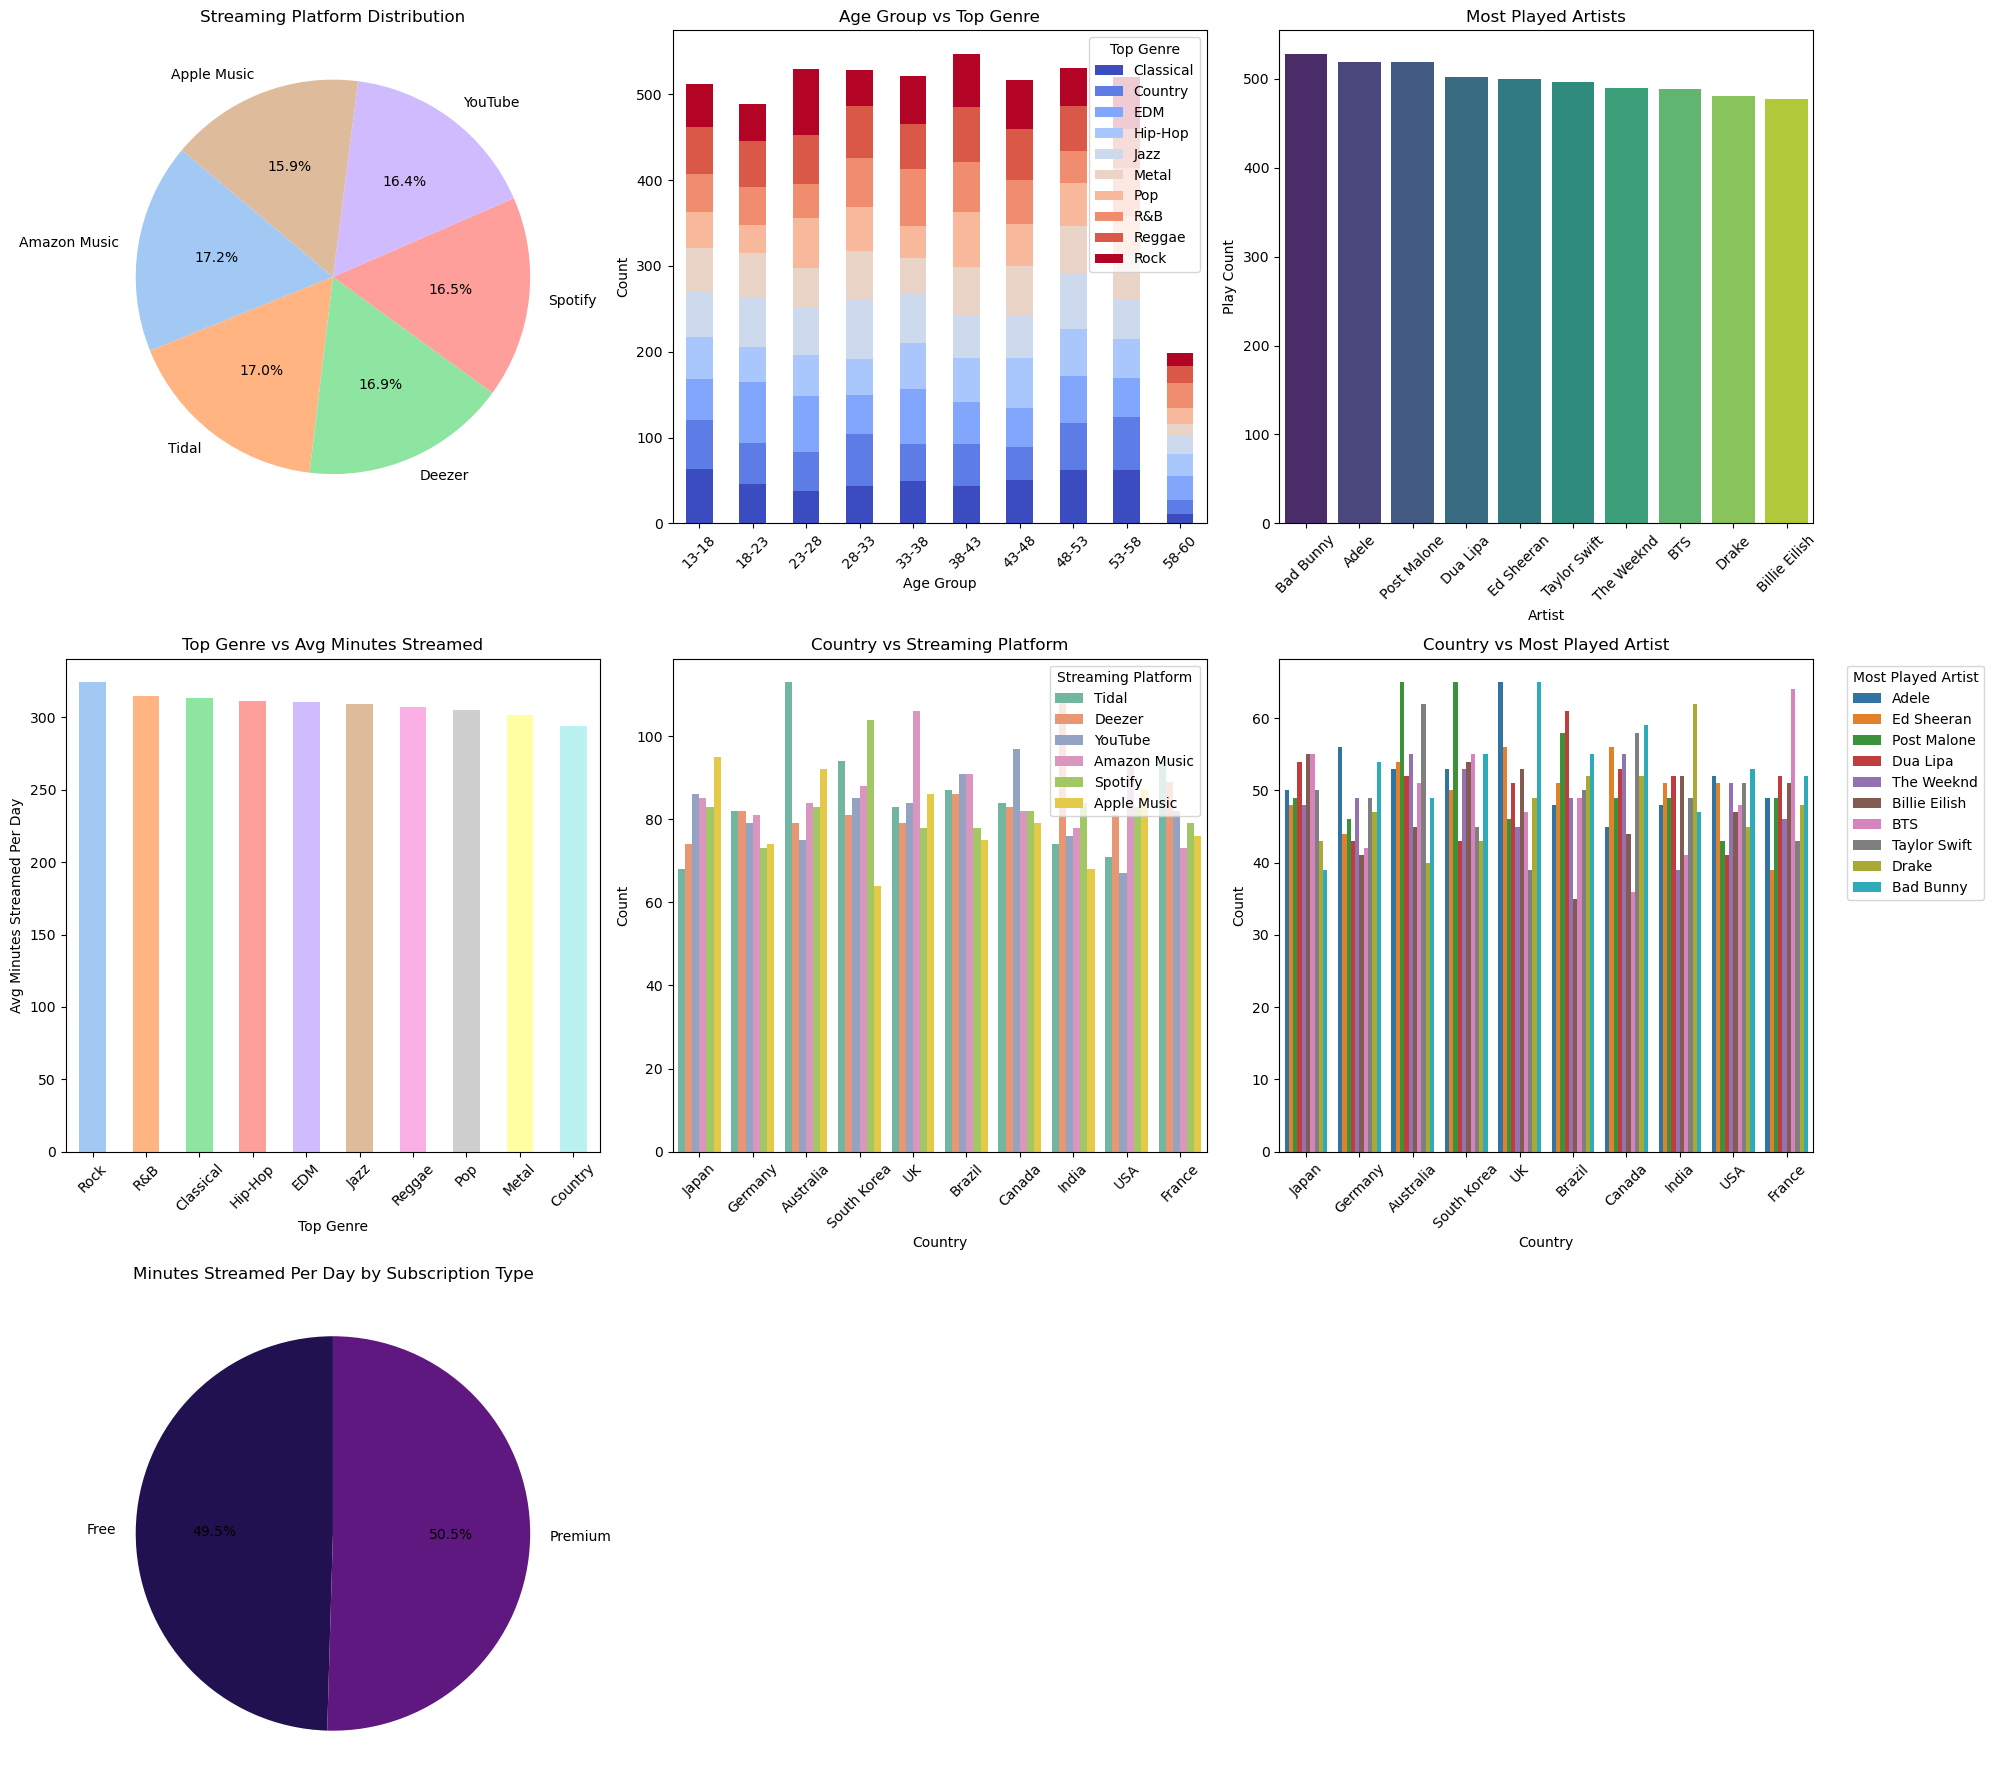

In [6]:


def visualize_data():
    df = pd.read_csv("/home/joy/Documents/music_data/music_data_cleaned.csv")
    save_path = "/home/joy/Documents/music_data"
    
    # Create a figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))  # 3 rows, 3 columns
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # First Visualization: Streaming Platform Distribution (Pie Chart)
    plat_count = df['Streaming Platform'].value_counts()
    axes[0].pie(plat_count, labels=plat_count.index, autopct='%1.1f%%', startangle=140, 
                colors=sns.color_palette("pastel", len(plat_count)))
    axes[0].set_title("Streaming Platform Distribution")

    # Second Visualization: Age Group vs Top Genre (Stacked Bar Plot)
    age_bins = [13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 60]
    age_labels = ['13-18', '18-23', '23-28', '28-33', '33-38', '38-43', '43-48', 
                  '48-53', '53-58', '58-60']
    df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    df.groupby(['Age Group', 'Top Genre']).size().unstack().plot(kind='bar', stacked=True, 
                                                                  colormap='coolwarm', ax=axes[1])
    axes[1].set_xlabel("Age Group")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Age Group vs Top Genre")
    axes[1].tick_params(axis='x', rotation=45)

    # Third Visualization: Most Played Artists (Bar Chart)
    artist_count = df['Most Played Artist'].value_counts().sort_values(ascending=False)
    sns.barplot(x=artist_count.index, y=artist_count.values, palette="viridis", ax=axes[2])
    axes[2].set_xlabel("Artist")
    axes[2].set_ylabel("Play Count")
    axes[2].set_title("Most Played Artists")
    axes[2].tick_params(axis='x', rotation=45)

    # Fourth Visualization: Top Genre vs Avg Minutes Streamed Per Day
    avg_minutes_per_genre = df.groupby('Top Genre')['Minutes Streamed Per Day'].mean().sort_values(ascending=False)
    avg_minutes_per_genre.plot(kind='bar', color=sns.color_palette('pastel'), ax=axes[3])
    axes[3].set_xlabel("Top Genre")
    axes[3].set_ylabel("Avg Minutes Streamed Per Day")
    axes[3].set_title("Top Genre vs Avg Minutes Streamed")
    axes[3].tick_params(axis='x', rotation=45)

    # Fifth Visualization: Country vs Streaming Platform (Count Plot)
    sns.countplot(data=df, x='Country', hue='Streaming Platform', palette="Set2", ax=axes[4])
    axes[4].set_xlabel("Country")
    axes[4].set_ylabel("Count")
    axes[4].set_title("Country vs Streaming Platform")
    axes[4].tick_params(axis='x', rotation=45)
    axes[4].legend(title="Streaming Platform")

    # Sixth Visualization: Country vs Most Played Artist (Count Plot)
    sns.countplot(data=df, x='Country', hue='Most Played Artist', palette="tab10", ax=axes[5])
    axes[5].set_xlabel("Country")
    axes[5].set_ylabel("Count")
    axes[5].set_title("Country vs Most Played Artist")
    axes[5].tick_params(axis='x', rotation=45)
    axes[5].legend(title="Most Played Artist", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Seventh Visualization: Subscription Type vs Minutes Streamed (Pie Chart)
    total_minutes = df.groupby('Subscription Type')['Minutes Streamed Per Day'].sum()
    total_minutes.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('magma'), 
                       startangle=90, ax=axes[6])
    axes[6].set_title("Minutes Streamed Per Day by Subscription Type")
    axes[6].set_ylabel("")  # Remove default ylabel

    # Hide extra subplots (axes[7] and axes[8] since we only have 7 plots)
    axes[7].set_visible(False)
    axes[8].set_visible(False)

    # Adjust layout for better readability
    plt.tight_layout()

    # Save the figure before showing it
    visualization_path = os.path.join(save_path, "music_visualizations.png")
    plt.savefig(visualization_path)
    print(f"Visualizations saved to {visualization_path}")

    # Show the figure
    plt.show()

# Call the function
visualize_data()

In [7]:
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2025, 3, 14),
    'retries': 4,
}

In [8]:
dag = DAG(
    'music_data_analysis',
    default_args=default_args,
    schedule_interval='@daily',
    catchup=False,
)

In [9]:
download_task = PythonOperator(
    task_id='download_data',
    python_callable=download_data,
    dag=dag,
)

In [10]:
load_task = PythonOperator(
    task_id='load_data',
    python_callable=load_data,
    dag=dag,
)

In [11]:
clean_task = PythonOperator(
    task_id='data_cleaning',
    python_callable=data_cleaning,
    dag=dag,
)

In [12]:
visualize_task = PythonOperator(
    task_id='visualize_data',
    python_callable=visualize_data,
    dag=dag,
)

In [13]:
download_task >> load_task >> clean_task >> visualize_task

<Task(PythonOperator): visualize_data>